In [7]:
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2

In [10]:
from simple_vector_db.quantization.vector_quantizer import VectorQuantizer
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_digits
import pandas as pd
import psutil
import numpy as np
import sys
import seaborn as sns

In [11]:
vectors_to_quantize = load_digits().data

In [106]:
m_chunks_list = range(2, 32, 2)
res = []
for m_chunk in m_chunks_list:
    k_centroids_list = np.array(range(2, 32, 2)) * m_chunk
    for k_centroids in k_centroids_list:
        try:
            quantizer = VectorQuantizer(m_chunks=m_chunk, nb_subspace_centroids=k_centroids)
            quantized_vectors = quantizer.quantize_vectors(vectors_to_quantize)
            print(m_chunk, k_centroids, (vectors_to_quantize.size * vectors_to_quantize.itemsize) / 1024,
                  (quantized_vectors.size * quantized_vectors.itemsize) / 1024)
            rebuilt_vector = quantizer.rebuild_vector(quantized_vectors[0])
            compression_mse = mean_squared_error(vectors_to_quantize[0], rebuilt_vector)
            res.append(
                {"Nombre de sections": m_chunk, "Nombre de centroïdes par section": k_centroids,
                 "mesure MSE": compression_mse,
                 "mémoire en kB": (quantized_vectors.size * quantized_vectors.itemsize) / 1024})
        except ValueError:
            print(m_chunk, k_centroids, "ERROR")

res = pd.DataFrame(res)

2 4 898.5 14.0390625
2 8 898.5 14.0390625
2 12 898.5 14.0390625
2 16 898.5 14.0390625
2 20 898.5 14.0390625
2 24 898.5 14.0390625
2 28 898.5 14.0390625
2 32 898.5 14.0390625
2 36 898.5 14.0390625
2 40 898.5 14.0390625
2 44 898.5 14.0390625
2 48 898.5 14.0390625
2 52 898.5 14.0390625
2 56 898.5 14.0390625
2 60 898.5 14.0390625
4 8 898.5 28.078125
4 16 898.5 28.078125
4 24 898.5 28.078125
4 32 898.5 28.078125
4 40 898.5 28.078125
4 48 898.5 28.078125
4 56 898.5 28.078125
4 64 898.5 28.078125
4 72 898.5 28.078125
4 80 898.5 28.078125
4 88 898.5 28.078125
4 96 898.5 28.078125
4 104 898.5 28.078125
4 112 898.5 28.078125
4 120 898.5 28.078125
2023-12-01 16:39:14,142 - ERROR - The vector's dimension 64 is not divisible by 6 - (vector_quantizer.py:44)
6 12 ERROR
2023-12-01 16:39:14,143 - ERROR - The vector's dimension 64 is not divisible by 6 - (vector_quantizer.py:44)
6 24 ERROR
2023-12-01 16:39:14,145 - ERROR - The vector's dimension 64 is not divisible by 6 - (vector_quantizer.py:44)
6 36 E

/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (272) found smaller than n_clusters (288). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (262) found smaller than n_clusters (288). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (272) found smaller than n_clusters (320). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


16 288 898.5 112.3125


/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (262) found smaller than n_clusters (320). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (272) found smaller than n_clusters (352). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


16 320 898.5 112.3125


/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (262) found smaller than n_clusters (352). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


16 352 898.5 112.3125


/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (272) found smaller than n_clusters (384). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (262) found smaller than n_clusters (384). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


16 384 898.5 112.3125


/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (272) found smaller than n_clusters (416). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (387) found smaller than n_clusters (416). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (262) found smaller than n_clusters (416). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


16 416 898.5 112.3125


/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (272) found smaller than n_clusters (448). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (387) found smaller than n_clusters (448). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (262) found smaller than n_clusters (448). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/philippe.stepniewski/

16 448 898.5 112.3125


/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (272) found smaller than n_clusters (480). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (387) found smaller than n_clusters (480). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


16 480 898.5 112.3125
2023-12-01 16:39:31,102 - ERROR - The vector's dimension 64 is not divisible by 18 - (vector_quantizer.py:44)
18 36 ERROR
2023-12-01 16:39:31,102 - ERROR - The vector's dimension 64 is not divisible by 18 - (vector_quantizer.py:44)
18 72 ERROR
2023-12-01 16:39:31,102 - ERROR - The vector's dimension 64 is not divisible by 18 - (vector_quantizer.py:44)
18 108 ERROR
2023-12-01 16:39:31,103 - ERROR - The vector's dimension 64 is not divisible by 18 - (vector_quantizer.py:44)
18 144 ERROR
2023-12-01 16:39:31,103 - ERROR - The vector's dimension 64 is not divisible by 18 - (vector_quantizer.py:44)
18 180 ERROR
2023-12-01 16:39:31,103 - ERROR - The vector's dimension 64 is not divisible by 18 - (vector_quantizer.py:44)
18 216 ERROR
2023-12-01 16:39:31,104 - ERROR - The vector's dimension 64 is not divisible by 18 - (vector_quantizer.py:44)
18 252 ERROR
2023-12-01 16:39:31,104 - ERROR - The vector's dimension 64 is not divisible by 18 - (vector_quantizer.py:44)
18 288 ER

/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (262) found smaller than n_clusters (480). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (439) found smaller than n_clusters (480). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [ ]:
res

In [107]:
#sns.kdeplot(data = res,x = "m_chunk", y = 'k_centroids',hue = "mse", fill = True)
#sns.set_style("whitegrid")
#colors = ["#4AB8CB", "#0C1944", "#737E9A", "#1293B0", "#505C7E","#0E2356"]
colors = ["#0E2356","#00A3BE","#00A795","#3E4F78","#33B5CB","#33B9AA","#33BD33","#6E7B9A","#66C8D8","#66CABF","#66CE66"]
# Set your custom color palette
custom_palette = sns.color_palette(colors)

/var/folders/6f/tzp_vm_s0g53_39ds1grlmsm0000gn/T/ipykernel_44547/1861817001.py:1: UserWarning: The palette list has more values (11) than needed (4), which may not be intended.
  sns_plot = sns.scatterplot(data=res, x="Nombre de centroïdes par section", y="mesure MSE", hue="Nombre de sections",


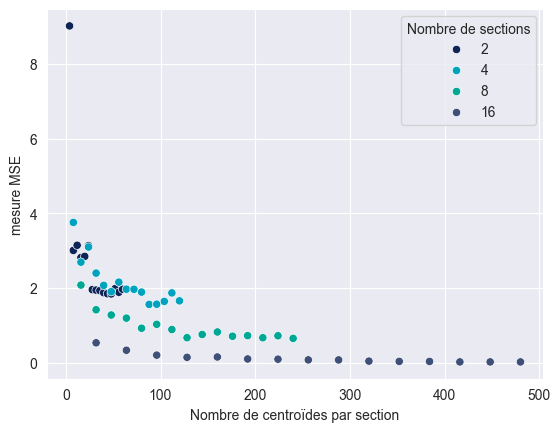

In [108]:
sns_plot = sns.scatterplot(data=res, x="Nombre de centroïdes par section", y="mesure MSE", hue="Nombre de sections",
                           palette=custom_palette)
fig = sns_plot.get_figure()
fig.savefig("../figures/mse_vs_params.png")

/var/folders/6f/tzp_vm_s0g53_39ds1grlmsm0000gn/T/ipykernel_44547/1448839332.py:1: UserWarning: The palette list has more values (11) than needed (4), which may not be intended.
  sns_plot = sns.scatterplot(data=res, x="Nombre de centroïdes par section", y="mémoire en kB", hue="Nombre de sections",


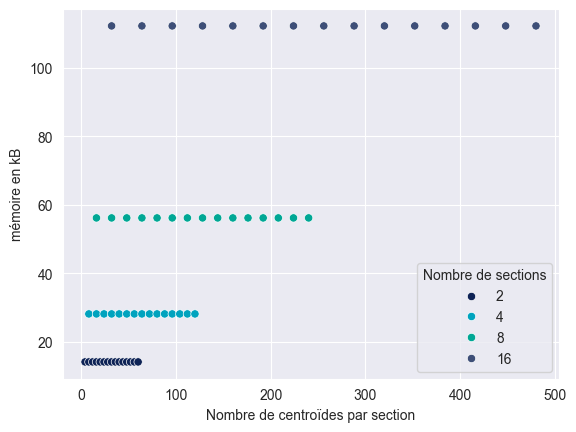

In [109]:
sns_plot = sns.scatterplot(data=res, x="Nombre de centroïdes par section", y="mémoire en kB", hue="Nombre de sections",
                           palette=custom_palette)
fig = sns_plot.get_figure()
fig.savefig("../figures/memory_vs_params.png")

## PQ parameters vs Recall 

/var/folders/6f/tzp_vm_s0g53_39ds1grlmsm0000gn/T/ipykernel_44547/4009237512.py:2: UserWarning: The palette list has more values (11) than needed (7), which may not be intended.
  sns_plot = sns.scatterplot(data=bench_kmeans, x="Nombre de centroïdes par section", y="rappel @ 10",


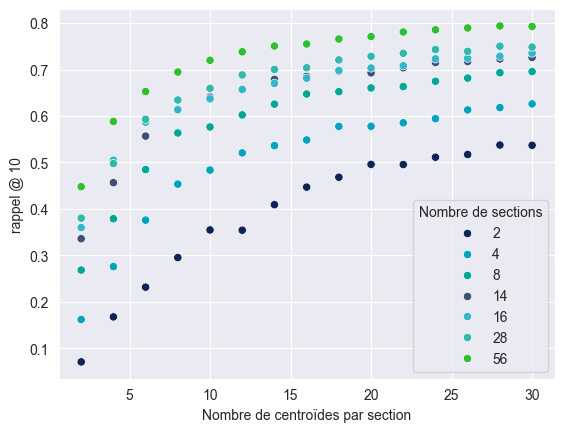

In [71]:
bench_kmeans = pd.read_csv("../figures/bench_results_pq.csv")
sns_plot = sns.scatterplot(data=bench_kmeans, x="Nombre de centroïdes par section", y="rappel @ 10",
                           hue="Nombre de sections",
                           palette=custom_palette)
fig = sns_plot.get_figure()
fig.savefig("../figures/pq_recall_vs_params.png")

## PQ RECALL VS SPEED

In [72]:
bench_kmeans.groupby("rappel @ 10").agg({"nb_requests_per_second":"mean"})

KeyError: "Column(s) ['nb_requests_per_second'] do not exist"

/var/folders/6f/tzp_vm_s0g53_39ds1grlmsm0000gn/T/ipykernel_44547/300564399.py:1: UserWarning: The palette list has more values (11) than needed (7), which may not be intended.
  sns_plot = sns.scatterplot(data=bench_kmeans, x="rappel @ 10", y="Nombre de requêtes par seconde",


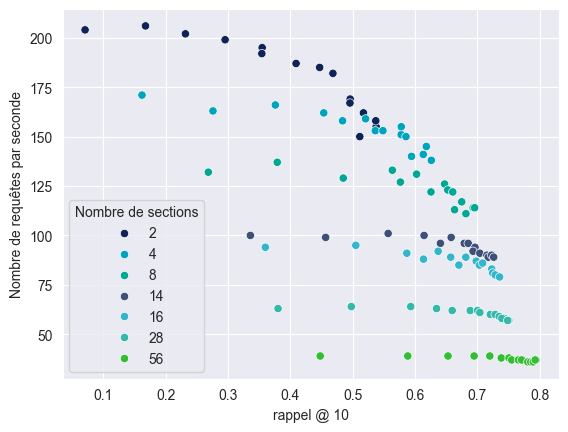

In [73]:

sns_plot = sns.scatterplot(data=bench_kmeans, x="rappel @ 10", y="Nombre de requêtes par seconde",
                           palette=custom_palette, hue="Nombre de sections")
fig = sns_plot.get_figure()
fig.savefig("../figures/pq_recall_vs_speed.png")

/var/folders/6f/tzp_vm_s0g53_39ds1grlmsm0000gn/T/ipykernel_44547/35607223.py:1: UserWarning: 
The palette list has fewer values (11) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns_plot = sns.scatterplot(data=bench_kmeans, x="rappel @ 10", y="Nombre de requêtes par seconde",


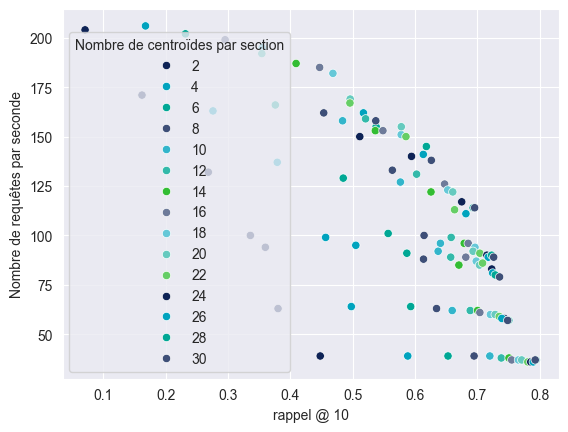

In [74]:

sns_plot = sns.scatterplot(data=bench_kmeans, x="rappel @ 10", y="Nombre de requêtes par seconde",
                           palette=custom_palette, hue="Nombre de centroïdes par section")
fig = sns_plot.get_figure()
fig.savefig("../figures/pq_recall_vs_speed.png")

## IVKMEANS parameters vs Recall 

/var/folders/6f/tzp_vm_s0g53_39ds1grlmsm0000gn/T/ipykernel_44547/1382992402.py:2: UserWarning: The palette list has more values (11) than needed (4), which may not be intended.
  sns_plot = sns.scatterplot(data=bench_kmeans, x="Nombre de clusters", y="Rappel @ 10",


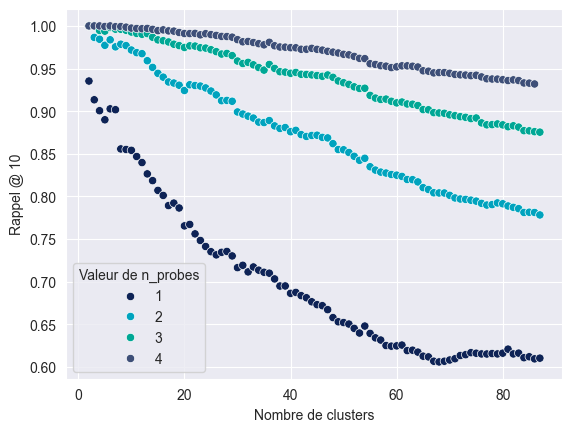

In [100]:
bench_kmeans = pd.read_csv("../figures/bench_results_kmeans.csv")
sns_plot = sns.scatterplot(data=bench_kmeans, x="Nombre de clusters", y="Rappel @ 10",
                           hue="Valeur de n_probes",
                           palette=custom_palette)
fig = sns_plot.get_figure()
fig.savefig("../figures/kmeans_recall_vs_params.png")

/var/folders/6f/tzp_vm_s0g53_39ds1grlmsm0000gn/T/ipykernel_44547/3479449761.py:1: UserWarning: The palette list has more values (11) than needed (4), which may not be intended.
  sns_plot = sns.scatterplot(data=bench_kmeans, x="Rappel @ 10", y="Nombre de requêtes par seconde",


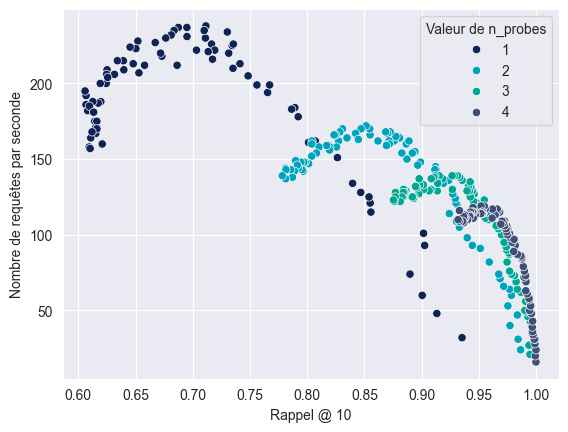

In [101]:
sns_plot = sns.scatterplot(data=bench_kmeans, x="Rappel @ 10", y="Nombre de requêtes par seconde",
                           palette=custom_palette,hue="Valeur de n_probes")
fig = sns_plot.get_figure()
fig.savefig("../figures/kmeans_recall_vs_speed_clusters_nprobs.png")

In [103]:
bench_kmeans['Intervalle du nombre de clusters '] = pd.cut(bench_kmeans["Nombre de clusters"], bins=5,precision=0)

    

/var/folders/6f/tzp_vm_s0g53_39ds1grlmsm0000gn/T/ipykernel_44547/3253170864.py:1: UserWarning: The palette list has more values (11) than needed (5), which may not be intended.
  sns_plot = sns.scatterplot(data=bench_kmeans, x="Rappel @ 10", y="Nombre de requêtes par seconde",


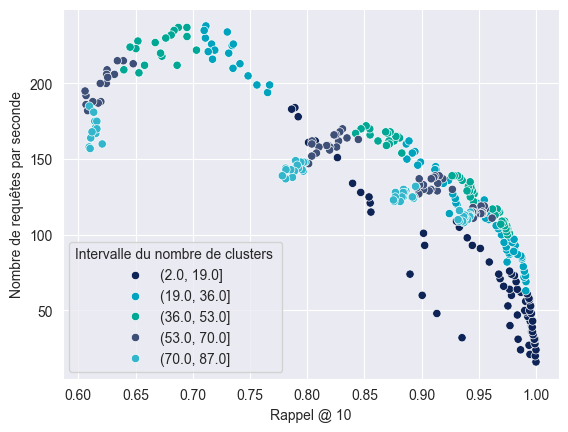

In [104]:
sns_plot = sns.scatterplot(data=bench_kmeans, x="Rappel @ 10", y="Nombre de requêtes par seconde",
                           palette=custom_palette,hue='Intervalle du nombre de clusters ')
fig = sns_plot.get_figure()
fig.savefig("../figures/kmeans_recall_vs_speed_clusters.png")

In [ ]:

sns_plot = sns.scatterplot(data=bench_kmeans, x="Rappel @ 10", y="Nombre de requêtes par seconde",
                           palette=custom_palette,hue='Intervalle du nombre de clusters ')
fig = sns_plot.get_figure()
fig.savefig("../figures/kmeans_recall_vs_speed_clusters.png")